In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [ ]:
import albumentations as A
import copy
import numpy as np
import torch 
from torch.utils.data import DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt 
import seaborn as sns 

from mermaidseg.datasets.dataset import Mermaid15Dataset, CoralNet15Dataset
from mermaidseg.model.meta import MetaModel
from mermaidseg.io import setup_config, get_parser, update_config_with_args
from mermaidseg.model.eval import EvaluatorSemanticSegmentation
from mermaidseg.visualization import denormalize_image

2025-10-28 11:46:45.123176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 11:46:45.137217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761652005.156193   30844 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761652005.164882   30844 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-28 11:46:45.183619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: Tesla T4


device(type='cuda')

## Config

In [6]:
cfg = setup_config(config_path='../configs/segformer-mit-b2.yaml', config_base_path='../configs/base.yaml')

args_input = "--run-name=notebook_test_run --batch-size=8 --epochs=10 --log-epochs=1"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg_logger = copy.deepcopy(cfg)

# 2. Data

In [7]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [8]:
dataset_mermaid = Mermaid15Dataset(transform = transforms["train"], padding = 3)
dataset_coralnet = CoralNet15Dataset(transform = transforms["train"], padding = 7)
len(dataset_mermaid), len(dataset_coralnet)

Initialize CoralNet to Mermaid LabelMapping


(3585, 19612)

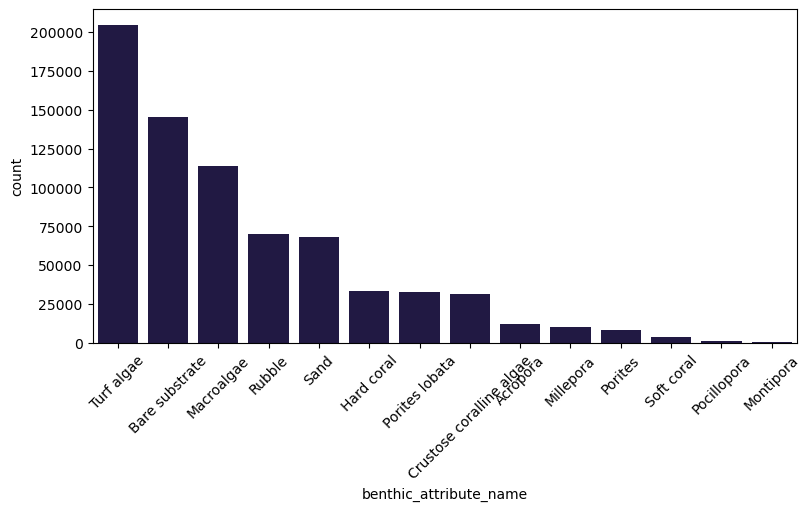

In [9]:
fig, ax = plt.subplots(figsize = (8, 5), layout = "compressed")
sns.barplot(dataset_coralnet.df_annotations["benthic_attribute_name"].value_counts(), color = "#1C124A")
plt.xticks(rotation = 45)
plt.show()

(3, 512, 512) (512, 512)


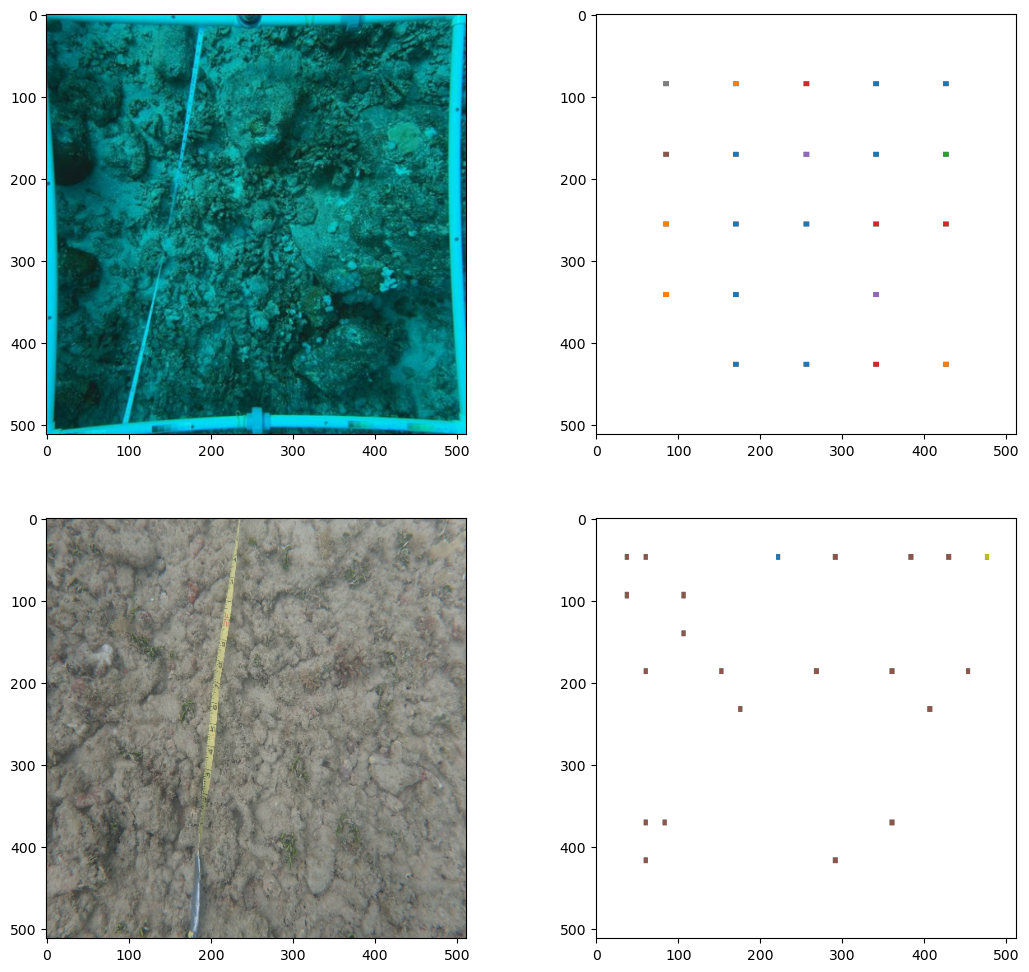

In [10]:
fig, ax = plt.subplots(figsize= (13,12), ncols = 2, nrows = 2)

image, mask, annotations = dataset_mermaid[0]
print(image.shape, mask.shape)

ax[0, 0].imshow(denormalize_image(image).transpose(1,2,0))
ax[0, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

image, mask, annotations = dataset_coralnet[0]

ax[1, 0].imshow(denormalize_image(image).transpose(1,2,0))
ax[1, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

plt.show()

In [11]:
from torch.utils.data import random_split

# Calculate lengths for train and test splits (80-20 split)
total_size = len(dataset_coralnet)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)
# Create train and val datasets
train_dataset, val_dataset, test_dataset = random_split(dataset_coralnet, [train_size, val_size, test_size], generator=generator)
# train_dataset = torch.utils.data.Subset(train_dataset, range(1000))
# val_dataset = torch.utils.data.Subset(val_dataset, range(500))
# test_dataset = torch.utils.data.Subset(test_dataset, range(300))

batch_size = 2
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset_coralnet.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset_coralnet.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset_coralnet.collate_fn)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 6864
Number of validation batches: 980
Number of test batches: 1961


In [12]:
for inputs, labels in train_loader:
    print(f"Batch shape: {inputs.shape}")
    print(f"Mask shape: {labels.shape}") 
    break

Batch shape: torch.Size([2, 3, 512, 512])
Mask shape: torch.Size([2, 512, 512])


# 3. Model

In [13]:
meta_model = MetaModel(run_name = cfg.run_name, 
                       num_classes = dataset_coralnet.num_classes,
                       device = device,
                       model_kwargs = cfg.model,
                       training_kwargs = cfg.training)

evaluator = EvaluatorSemanticSegmentation(num_classes=dataset_coralnet.num_classes,
                                            device=device,
                                            )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 Load Checkpoint

In [14]:
model_checkpoint = "./model_checkpoints/notebook_test_run/model_2025102807"
checkpoint = torch.load(model_checkpoint, weights_only=False)

In [15]:
checkpoint.keys()

dict_keys(['config', 'model_state_dict', 'optimizer_state_dict', 'epoch', 'timestamp', 'metrics', 'scheduler_state_dict'])

In [16]:
checkpoint["metrics"], checkpoint["epoch"]

({'accuracy': 0.8627805709838867, 'mean_iou': 0.6417348384857178}, 9)

In [17]:
meta_model.model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## 3.2 Load Metrics over Epochs

In [18]:
import pandas as pd

In [19]:
metrics_path = "./mlruns/676445861567137307/5eaa1dbbbad34482b0b8401f8ccd7a9c/metrics/"

In [20]:
metrics_dict = {}
for split in ["train", "validation"]:
    for metric in ["loss", "accuracy", "mean_iou"]:
        with open(f'{metrics_path}{split}/{metric}') as f:
            metric_results = f.readlines()
            metric_results = [float(row.split()[1]) for row in metric_results]
            metrics_dict[f"{split}_{metric}"] = metric_results

In [21]:
df_metrics = pd.DataFrame(metrics_dict)
df_metrics

,train_loss,train_accuracy,train_mean_iou,validation_loss,validation_accuracy,validation_mean_iou
0,0.847100,0.812787,0.502321,0.574263,0.806196,0.482403
1,0.574622,0.819728,0.553662,0.557278,0.809329,0.502373
2,0.494349,0.849466,0.622276,0.492015,0.831565,0.576497
3,0.436930,0.854539,0.643447,0.468316,0.839168,0.594322
4,0.391724,0.875944,0.672397,0.437815,0.844817,0.609072
5,0.354556,0.886963,0.699984,0.437574,0.853842,0.614969
6,0.319836,0.899588,0.731073,0.428880,0.855230,0.627281
7,0.286255,0.910783,0.759003,0.436320,0.858309,0.631396
8,0.260938,0.917626,0.774080,0.426254,0.861805,0.638752
9,0.242345,0.922762,0.785046,0.428002,0.862781,0.641735


# 4. Evaluation

## 4.1 Model Training Curves

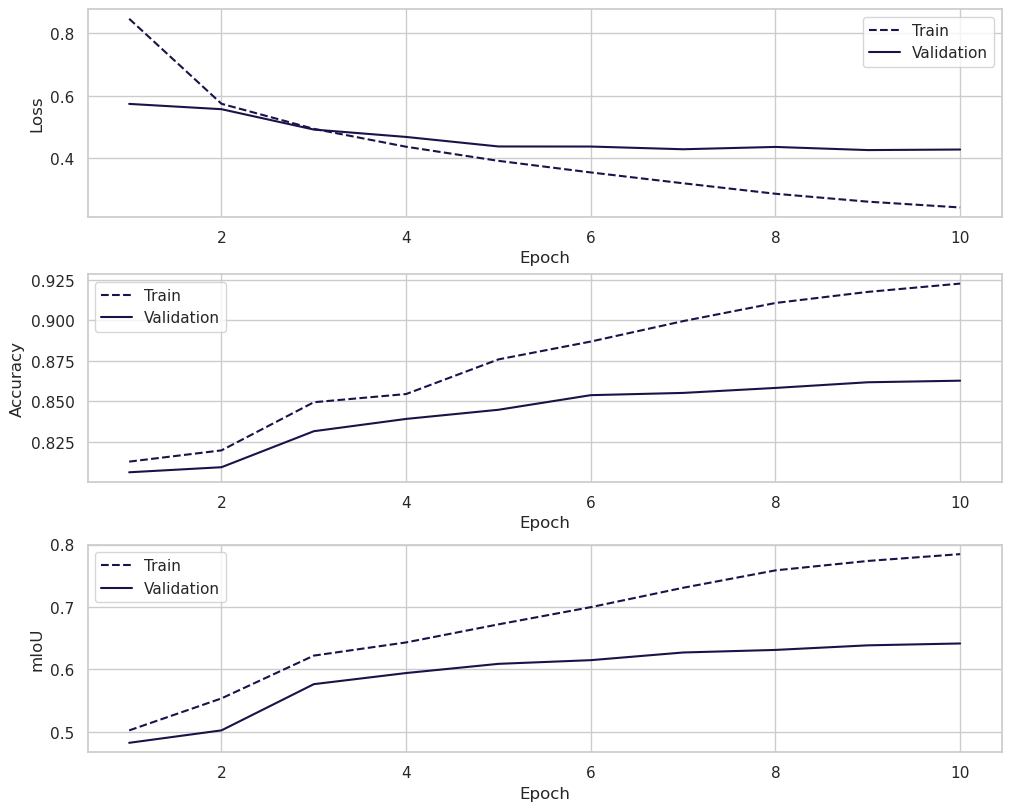

In [22]:
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize=(10, 8), nrows = 3, layout = "compressed")
plt.subplot(3, 1, 1)
plt.plot(range(1, len(metrics_dict["train_loss"]) + 1), metrics_dict["train_loss"], label='Train', linestyle = "--", color = "#1C124A")
plt.plot(range(1, len(metrics_dict["validation_loss"]) + 1), metrics_dict["validation_loss"], label='Validation', color = "#1C124A")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(1, len(metrics_dict["train_accuracy"]) + 1), metrics_dict["train_accuracy"], label='Train', linestyle = "--", color = "#1C124A")
plt.plot(range(1, len(metrics_dict["validation_accuracy"]) + 1), metrics_dict["validation_accuracy"], label='Validation', color = "#1C124A")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(1, len(metrics_dict["train_mean_iou"]) + 1), metrics_dict["train_mean_iou"], label='Train', linestyle = "--", color = "#1C124A")
plt.plot(range(1, len(metrics_dict["validation_mean_iou"]) + 1), metrics_dict["validation_mean_iou"], label='Validation', color = "#1C124A")
plt.xlabel('Epoch')
plt.ylabel('mIoU')
# plt.title('Training and Validation IoU Over Time')
plt.legend()
plt.show()

## 4.2 Quantitative Analysis

In [23]:
from torchmetrics.classification import Accuracy, F1Score, JaccardIndex

metric_dict = {
            "accuracy": Accuracy(task="multiclass", num_classes=int(dataset_coralnet.num_classes), ignore_index = 0).to(device),
            "f1_macro": F1Score(task="multiclass", average = "macro", num_classes=int(dataset_coralnet.num_classes), ignore_index = 0).to(device),
            "f1_class": F1Score(task="multiclass", average = "none", num_classes=int(dataset_coralnet.num_classes), ignore_index = 0).to(device),
            "mean_iou": JaccardIndex(task="multiclass", num_classes=int(dataset_coralnet.num_classes), ignore_index = 0).to(device),
            "iou": JaccardIndex(task="multiclass", num_classes=int(dataset_coralnet.num_classes), ignore_index = 0, average='none').to(device)
            }

evaluator_final = EvaluatorSemanticSegmentation(num_classes=dataset_coralnet.num_classes,
                                            device=device,
                                            metric_dict = metric_dict
                                            )

final_test_results = evaluator_final.evaluate_model(dataloader = test_loader, meta_model=meta_model)

In [24]:
print(final_test_results["accuracy"], final_test_results["f1_macro"], final_test_results["mean_iou"])

0.8600571155548096 0.7795982956886292 0.6561195254325867


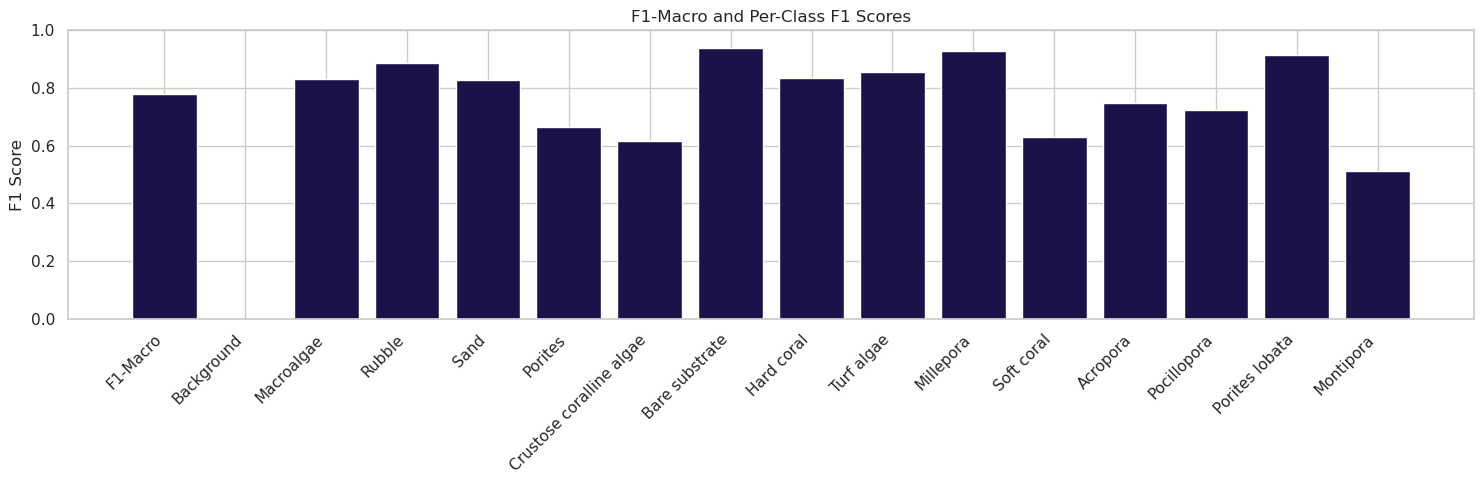

In [25]:
f1_values = [final_test_results["f1_macro"]] + final_test_results["f1_class"].tolist()
labels = ["F1-Macro", "Background", ] + list(dataset_coralnet.label2id.keys())

plt.figure(figsize=(15,5))
plt.bar(range(len(f1_values)), f1_values, color = "#1C124A")
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("F1-Macro and Per-Class F1 Scores")
plt.tight_layout()
plt.show()

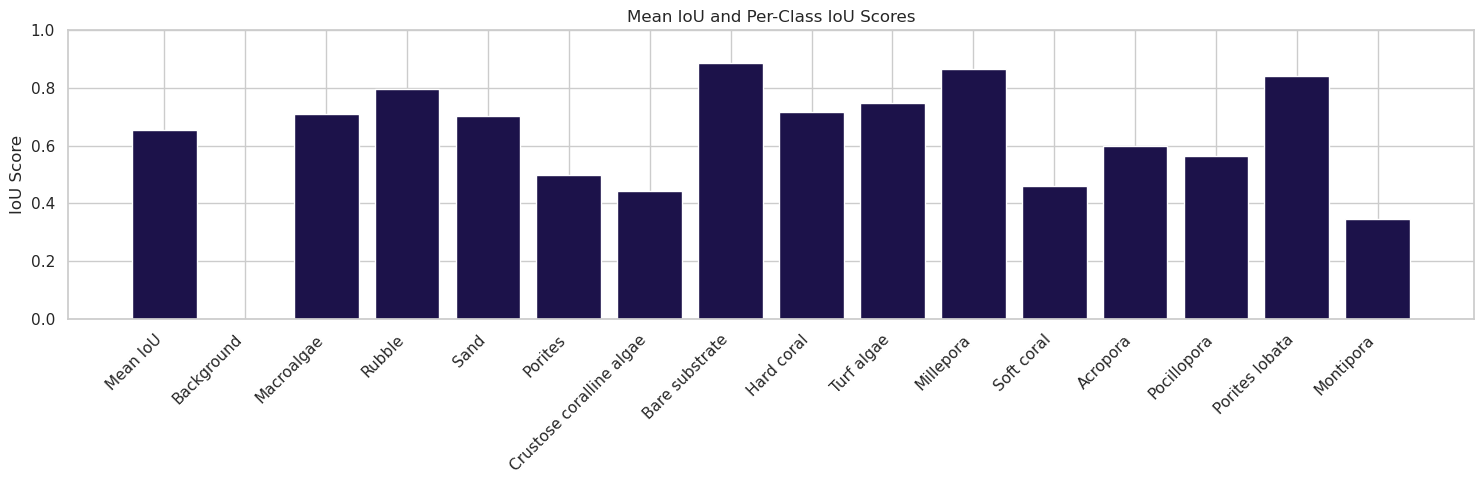

In [26]:
iou_values = [final_test_results["mean_iou"]] + final_test_results["iou"].tolist()
labels = ["Mean IoU", "Background"] + list(dataset_coralnet.label2id.keys())

plt.figure(figsize=(15,5))
plt.bar(range(len(iou_values)), iou_values,color = "#1C124A")
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel("IoU Score")
plt.ylim(0, 1)
plt.title("Mean IoU and Per-Class IoU Scores")
plt.tight_layout()
plt.show()

## 4.3 Qualitative Analysis

In [27]:
label2color = {"Sand": [194, 178, 128], "Rubble": [161, 153, 128], "Macroalgae" : [125, 163, 125], 
 "Porites": [255, 111, 194], "Porites lobata": [85, 53, 116], "Crustose coralline algae": [236, 150, 21],
 "Bare substrate": [125, 125, 125], "Hard coral": [224, 118, 119], "Turf algae": [0, 231, 255], 
 "Millepora": [244, 150, 115], "Soft coral": [255, 255, 0], 
 "Acropora": [236, 128, 255], "Pocillopora": [255, 146, 150], "Montipora": [240, 80, 80]}

id2color = {k:label2color[v] for k,v in dataset_coralnet.id2label.items()}
id2color[0] = [255, 255, 255] # background

In [28]:
test_loader_tmp = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset_coralnet.collate_fn)
image, label, pred_proba = evaluator_final.evaluate_image(dataloader = test_loader_tmp, meta_model = meta_model, proba = True, epoch = 3)
pred_proba_sigmoid = F.sigmoid(torch.from_numpy(pred_proba)).numpy()
pred_argmax = pred_proba.argmax(axis=0)

threshold = 0.8
pred_thresh = pred_proba_sigmoid.argmax(axis=0)
pred_thresh[pred_proba_sigmoid.max(axis=0)<threshold] = 0

label_colors = np.array([[id2color[pixel] for pixel in row] for row in np.array(label)]) 
pred_argmax_colors = np.array([[id2color[pixel] for pixel in row] for row in np.array(pred_argmax)]) 
pred_thresh_colors = np.array([[id2color[pixel] for pixel in row] for row in np.array(pred_thresh)]) 

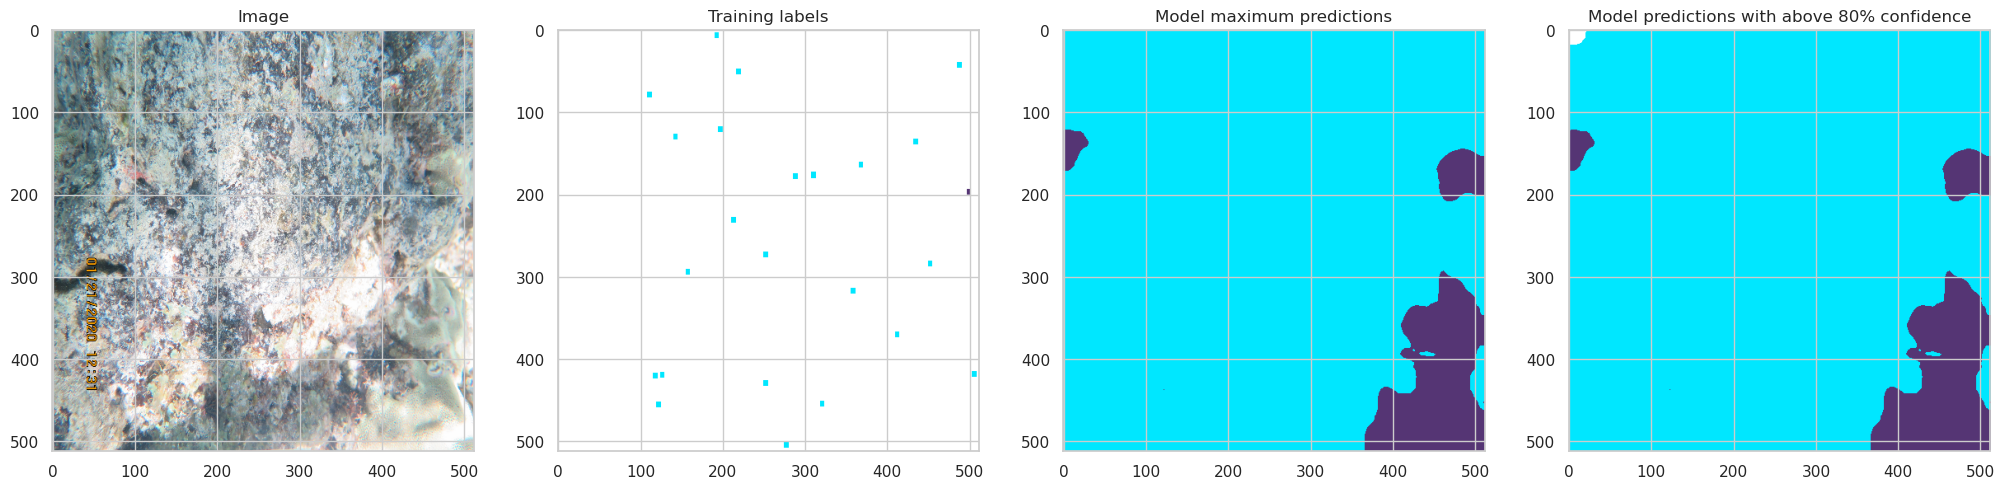

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
ax[0].imshow(denormalize_image(image).transpose(1, 2, 0))
ax[0].set_title("Image")
ax[1].imshow(label_colors)
ax[1].set_title("Training labels")
ax[2].imshow(pred_argmax_colors)
ax[2].set_title("Model maximum predictions")
ax[3].imshow(pred_thresh_colors)
ax[3].set_title("Model predictions with above 80% confidence")
plt.show()

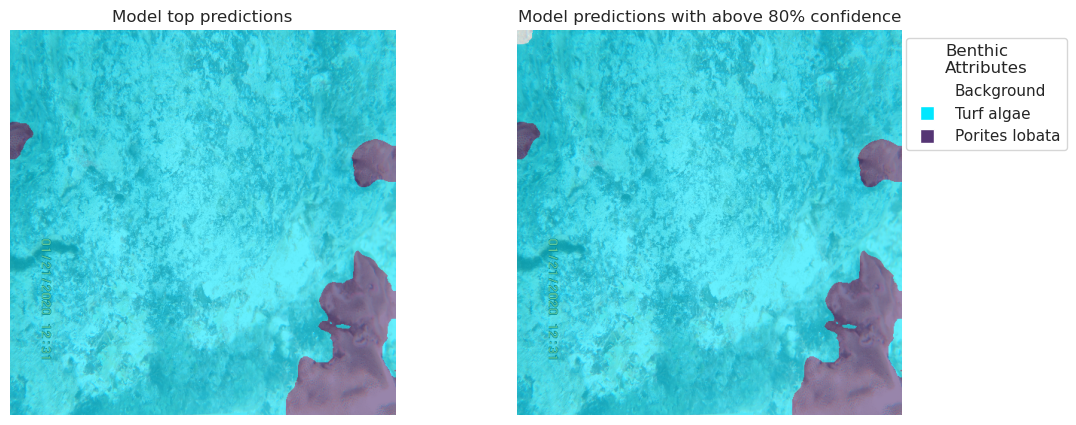

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(denormalize_image(image).transpose(1, 2, 0))
ax[0].imshow(pred_argmax_colors, alpha=0.6)
ax[0].set_title("Model top predictions")
ax[0].axis("off")
    
ax[1].imshow(denormalize_image(image).transpose(1, 2, 0))
ax[1].imshow(pred_thresh_colors, alpha=0.6)
ax[1].set_title("Model predictions with above 80% confidence")
ax[1].axis("off")

id2label_tmp = dataset_coralnet.id2label
id2label_tmp[0] = "Background"
benthic_legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="s",
            color="w",
            markerfacecolor=color,
            label=name,
            markersize=10,
        )
        for name, color in zip(
            [id2label_tmp[int(l)] for l in np.unique(pred_thresh)], ['#%02x%02x%02x' % tuple(id2color[int(l)]) for l in np.unique(pred_thresh)]
        )
    ]

first_legend = plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
                            loc='upper left', title='Benthic\nAttributes')
plt.show()

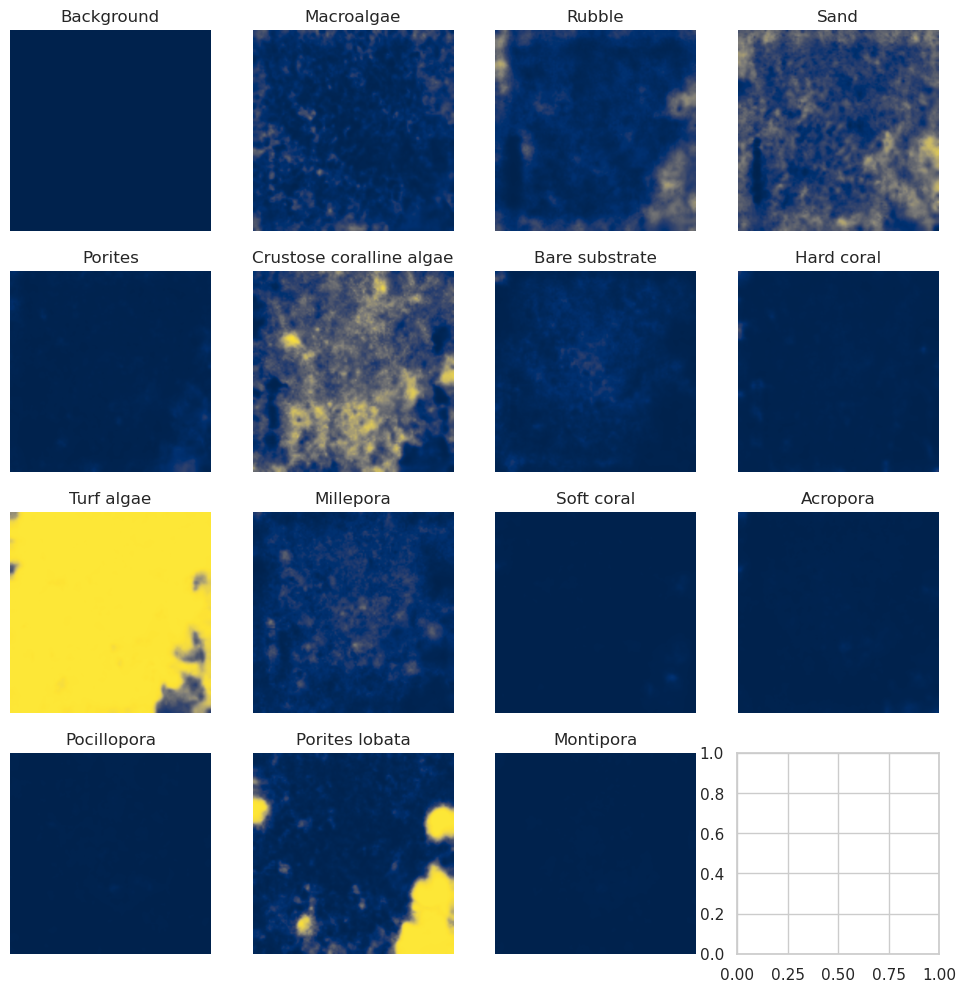

In [31]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.flatten()
for i, ax in enumerate(ax[:15]):
    ax.imshow(pred_proba_sigmoid[i], cmap="cividis", vmin = 0, vmax = 1)
    if i == 0:
        ax.set_title(f"Background")
    else:
        ax.set_title(f"{dataset_coralnet.id2label[i]}")
    ax.axis('off')
plt.show()